In [3]:
import pandas as pd

data = pd.read_csv("../data/inadimplencia.csv")
data.head()

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,12600.0,3569.400000,12.157324,1,2.0,0.057153,0.527227,0.513171,0.117428,2545.0,0
1,9000.0,2722.188351,7.000000,0,2.0,0.657661,0.285898,0.614414,0.222700,495.0,0
2,15750.0,4477.500000,12.000000,0,2.0,0.501213,0.695423,0.513171,0.117428,1212.0,0
3,9000.0,1309.050000,12.157324,0,3.0,0.501213,0.155973,0.513171,0.117428,515.0,0
4,7650.0,1125.000000,12.157324,0,2.0,0.294328,0.152076,0.513171,0.117428,162.0,0


In [4]:
# separacao das variaveis explicativas e alvo

x = data.drop("inadimplente", axis=1)
y = data["inadimplente"]

In [5]:
# como aparentemente nao ha variaveis categoricas e a alvo ja esta em formato numerico, nao vai precisar de nenhuma transofrmacao nesse sentido
# divisao dos dados vai ser % para treino e 15% para teste

from sklearn.model_selection import train_test_split

x, x_teste, y, y_teste = train_test_split(
    x, y, random_state=5, test_size=0.15, stratify=y
)
x_treino, x_validacao, y_treino, y_validacao = train_test_split(
    x, y, random_state=5, stratify=y
)

In [6]:
from sklearn.tree import DecisionTreeClassifier

arvore = DecisionTreeClassifier(random_state=12, max_depth=10)
arvore.fit(x_treino, y_treino)
print(arvore.score(x_teste, y_teste))
print(arvore.score(x_validacao, y_validacao))

0.9067127344521224
0.9057573382109573


## matriz de confusao

[[10356   123]
 [  959    43]]


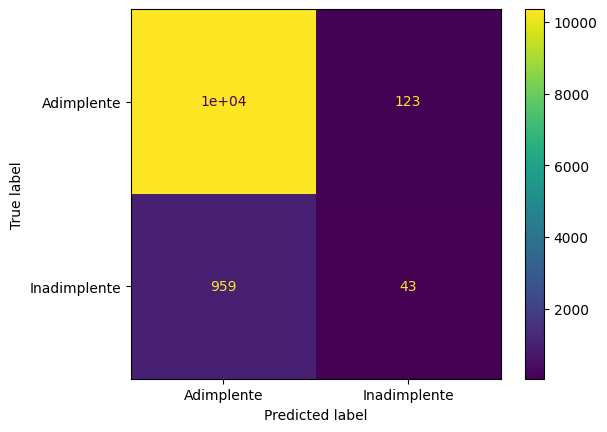

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_prev = arvore.predict(x_validacao)
matriz_confusao = confusion_matrix(y_validacao, y_prev)
print(matriz_confusao)

visualizacao = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=["Adimplente", "Inadimplente"])
visualizacao.plot()

## random forest

0.9125123395853899
[[10477     2]
 [  998     4]]


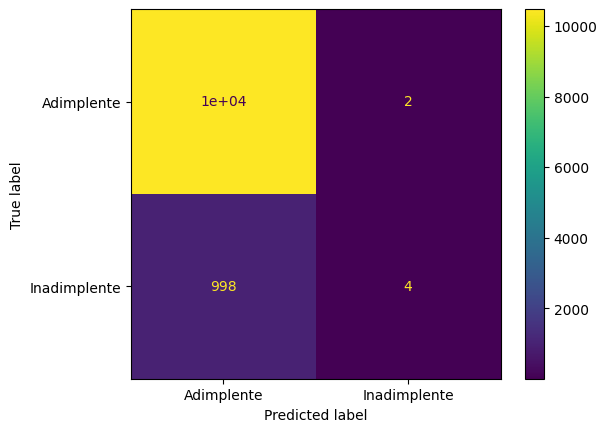

In [8]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier(random_state=12, max_depth=10)
modelo.fit(x_treino, y_treino)
print(modelo.score(x_teste, y_teste))

y_prev_forest = modelo.predict(x_validacao)
matriz_confusao_forest = confusion_matrix(y_validacao, y_prev_forest)
print(matriz_confusao_forest)

visualizacao = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_forest, display_labels=["Adimplente", "Inadimplente"])
visualizacao.plot()

In [9]:
from sklearn.metrics import accuracy_score

# matriz é 
# [[TP  FP]
# [FN  TN]]
print("acuracia: ", accuracy_score(y_validacao, y_prev_forest))
# a acuracia nao é uma metrica adequada porque a base de dados é desbalanceada = tp + tn / tp + tn + fp + fn

# a precisao = verdadeiros positivos / (verdadeiros positivos + falsos positivos)
from sklearn.metrics import precision_score
print("precisao: ", precision_score(y_validacao, y_prev_forest))

# o recall leva em consideracao os falsos negativos = verdadeiros positivos / (verdadeiros positivos + falsos negativos)
from sklearn.metrics import recall_score
print("recall: ", recall_score(y_validacao, y_prev_forest))


acuracia:  0.9128995732079087
precisao:  0.6666666666666666
recall:  0.003992015968063872


a metrica mais relevante depende do contexto do problema, no caso de inadimplencia, o recall é mais relevante, pois queremos identificar os inadimplentes, para evitar prejuizos, os falsos positivos apenas farao perder clientes bons, mas os falsos negativos podem gerar prejuizos financeiros maiores


In [10]:
from sklearn.metrics import f1_score
# f1 score é a media harmonica entre precisao e recall, = 2 x precisao x recall / (precisao + recall)

print("f1 score: ", f1_score(y_validacao, y_prev_forest))

f1 score:  0.007936507936507936


## curva roc

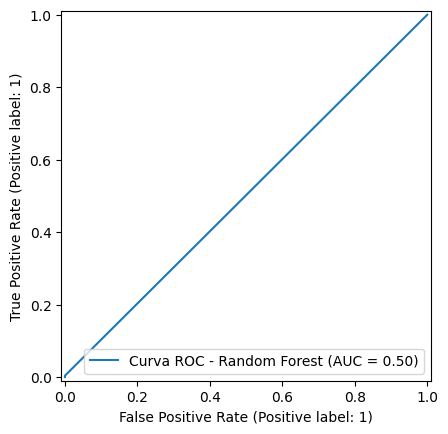

In [11]:
# a curva roc serve para avaliar se o nosso modelo ta conseguindo diferenciar bem uma classe da outra

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_validacao, y_prev_forest, name="Curva ROC - Random Forest")


In [12]:
from sklearn.metrics import roc_auc_score

print("AUC ROC: ", roc_auc_score(y_validacao, y_prev_forest))

AUC ROC:  0.5019005790308876


AUC PR:  0.09464563086733557


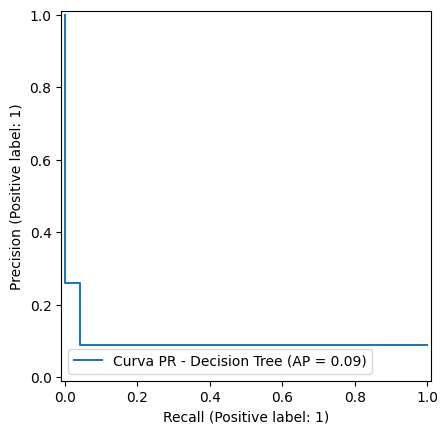

In [13]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

PrecisionRecallDisplay.from_predictions(y_validacao, y_prev, name="Curva PR - Decision Tree")
print("AUC PR: ", average_precision_score(y_validacao, y_prev))

## relatorio de metricas

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_validacao, y_prev_forest, target_names=["Adimplente", "Inadimplente"]))

              precision    recall  f1-score   support

  Adimplente       0.91      1.00      0.95     10479
Inadimplente       0.67      0.00      0.01      1002

    accuracy                           0.91     11481
   macro avg       0.79      0.50      0.48     11481
weighted avg       0.89      0.91      0.87     11481



## validacao cruzada - KFold

In [15]:
from sklearn.model_selection import KFold, cross_validate

In [16]:
def intevalo_confianca(resultados, metrica="test_score"):
    media = resultados[metrica].mean()
    desvio_padrao = resultados[metrica].std()
    print(f"Intervalo de confiança({metrica}): [{media-2*desvio_padrao}, {min(media+2*desvio_padrao, 1.0)}]")

In [17]:
def relatorio_metricas(resultados):
    for metrica in ['test_accuracy', 'test_recall', 'test_precision', 'test_f1']:
        intevalo_confianca(resultados, metrica=metrica)


In [18]:
modelo = DecisionTreeClassifier(max_depth = 10)
kf = KFold(n_splits=5, shuffle = True, random_state = 5)
cv_resultados = cross_validate(modelo, x, y, cv=kf, scoring = ['accuracy','recall', 'precision', 'f1'])
cv_resultados


{'fit_time': array([0.1175499 , 0.11785603, 0.11724782, 0.11628199, 0.1157732 ]),
 'score_time': array([0.00599217, 0.00562096, 0.00558209, 0.00580788, 0.00541091]),
 'test_accuracy': array([0.91355471, 0.90766551, 0.90766551, 0.91365418, 0.89949913]),
 'test_recall': array([0.02642008, 0.01856436, 0.01845018, 0.01697128, 0.02312139]),
 'test_precision': array([0.25974026, 0.21428571, 0.23076923, 0.24528302, 0.20408163]),
 'test_f1': array([0.04796163, 0.03416856, 0.03416856, 0.03174603, 0.04153686])}

In [19]:
relatorio_metricas(cv_resultados)

Intervalo de confiança(test_accuracy): [0.8980354730953676, 0.9187801386333451]
Intervalo de confiança(test_recall): [0.013656583706200397, 0.027754331035532202]
Intervalo de confiança(test_precision): [0.1904945435649966, 0.2711693989614796]
Intervalo de confiança(test_f1): [0.025910319455828862, 0.04992234304368817]


## estratificacao dos dados

In [20]:
data["inadimplente"].value_counts(normalize=True)

inadimplente
0    0.912707
1    0.087293
Name: proportion, dtype: float64

In [21]:
from sklearn.model_selection import StratifiedKFold #mantem a proporcao entre os dados

modelo = DecisionTreeClassifier(max_depth=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(modelo, x, y, cv= skf, scoring="recall")
cv_resultados


{'fit_time': array([0.11660004, 0.11495614, 0.11569285, 0.11689186, 0.11522508]),
 'score_time': array([0.00258803, 0.0024209 , 0.00244617, 0.00263405, 0.00251818]),
 'test_score': array([0.03491272, 0.02746567, 0.0286783 , 0.02244389, 0.0286783 ])}

## Oversampling - Smote

In [22]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_balanceado, y_balanceado = oversample.fit_resample(x, y)

y_balanceado.value_counts(normalize=True)


inadimplente
0    0.5
1    0.5
Name: proportion, dtype: float64

In [23]:
modelo = DecisionTreeClassifier(max_depth=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(modelo, x_balanceado, y_balanceado, cv=skf, scoring="recall")

In [24]:
cv_resultados

{'fit_time': array([0.24409485, 0.24455786, 0.24367285, 0.24207902, 0.26884604]),
 'score_time': array([0.00403833, 0.00396514, 0.0039711 , 0.00421381, 0.00412893]),
 'test_score': array([0.70901933, 0.71283703, 0.73839914, 0.72754384, 0.73979957])}

Alguns dos algoritmos de oversampling da biblioteca:

RandomOversampler
SMOTE
ADASYN
KMeansSMOTE
Alguns dos algoritmos de undersampling da biblioteca:

RandomUnderSampler
NearMiss
ClusterCentroids
TomekLinks
Algoritmos que combinam as duas técnicas de oversampling e undersampling:

SMOTEENN
SMOTETomek

o nosso resultado melhorou, porem é importante lembrar que os dados na vida real nao estarao balanceados, entao é importante fazer o teste com os dados desbalanceados

In [25]:
from imblearn.pipeline import Pipeline as imbpipeline

modelo = DecisionTreeClassifier()
pipeline = imbpipeline([
    ("oversample", SMOTE()),
    ("arvore", modelo)
])

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(pipeline, x, y, cv=skf, scoring="recall")

intevalo_confianca(cv_resultados)

Intervalo de confiança(test_score): [0.2372602904784956, 0.33245835921437594]


## Undersampling - NearMiss

NearMiss, que consiste em selecionar amostras da categoria em maior quantidade que possuem um padrão próximo da categoria com menor quantidade, no intuito de preservar informações importantes para a modelagem do problema. Por utilizar um critério de seleção das amostras, esse método é bem mais recomendado que a utilização de um undersampling puramente aleatório, que pode eliminar informações relevantes dos dados.

Para selecionar as amostras, esse algoritmo utiliza um método conhecido como vizinho mais próximo. Esse método é aplicado em 3 passos:

1º passo: são calculadas distâncias entre todas as amostras da classe com maior frequência e da classe com menor frequência.
2º passo: em seguida, para cada amostra da classe de menor frequência, são selecionadas n amostras da classe de maior frequência; por padrão esse número é 3 e vem daí o nome de vizinhos mais próximos. São selecionados 3 vizinhos mais próximos para cada amostra da classe de menor frequência.
3º passo: a partir dos elementos que foram selecionados, ocorre um novo processo de seleção para que fique com a mesma quantidade de elementos da classe de menor frequência. Essa seleção final possui 3 diferentes versões:
NearMiss versão 1: é calculada uma média entre as distâncias dos 3 vizinhos mais próximos de cada amostra da classe de maior frequência e são escolhidos aqueles que possuírem a menor média de distância.

NearMiss versão 2: é calculada uma média entre as distâncias dos 3 vizinhos mais distantes de cada amostra da classe de maior frequência e são escolhidos aqueles que possuírem a menor média de distância.

NearMiss versão 3: é dividido em duas etapas. Primeiramente, para cada elemento da classe de menor frequência, M vizinhos mais próximos são escolhidos e armazenados, por padrão o M também é de 3 vizinhos. Depois é calculada a média das distâncias entre os elementos armazenados e os elementos da classe de menor frequência e são escolhidos aqueles que possuírem maior média de distância.

In [27]:
from imblearn.under_sampling import NearMiss

modelo = DecisionTreeClassifier(max_depth=10)
pipeline = imbpipeline([("undersample", NearMiss(version=3)), ("arvore", modelo)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(pipeline, x, y, cv=skf, scoring="recall")

intevalo_confianca(cv_resultados)

Intervalo de confiança(test_score): [0.6196707527384523, 0.7043313518627164]


## Testando o modelo

In [28]:
undersample = NearMiss(version=3)
x_balanceado, y_balanceado = undersample.fit_resample(x, y)

modelo = DecisionTreeClassifier(max_depth=10)
modelo.fit(x_balanceado, y_balanceado)
y_prev = modelo.predict(x_teste)

print(classification_report(y_teste, y_prev))

              precision    recall  f1-score   support

           0       0.94      0.48      0.64      7397
           1       0.11      0.70      0.20       707

    accuracy                           0.50      8104
   macro avg       0.53      0.59      0.42      8104
weighted avg       0.87      0.50      0.60      8104



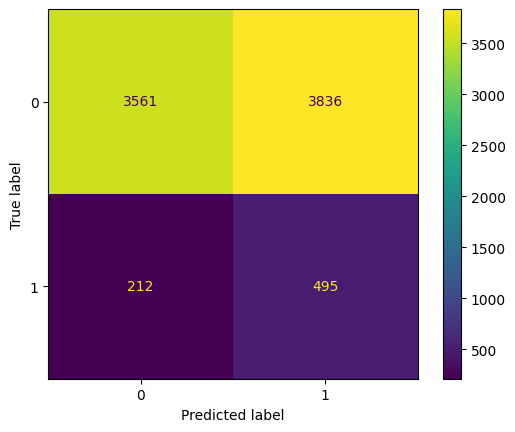

In [29]:
ConfusionMatrixDisplay.from_predictions(y_teste, y_prev)

pudemos observar que esses passos nao foram suficientes para solucionar esse desafio